In [9]:
import sys
!{sys.executable} -m pip install scikit-learn imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 36.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 56.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 25.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

# Validación y búsqueda de hiperparámetros
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, TimeSeriesSplit,
    GridSearchCV, RandomizedSearchCV
)

# Métricas (en desbalance nos importan más PR-AUC y recall)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
)
# Desbalance (opcional si no usamos class_weight='balanced')
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Guardado del modelo
import joblib

In [12]:
# 1. Cargar la base de datos correcta
df = pd.read_csv("american_bankruptcy_renamed.csv")

#  dimensiones y primeras filas
print(df.shape)
df.head()

(78682, 21)


,company_name,status_label,year,current_assets,cost_of_goods_sold,depreciation_amortization,ebitda,inventory,net_income,total_receivables,...,net_sales,total_assets,total_long_term_debt,ebit,gross_profit,total_current_liabilities,retained_earnings,total_revenue,total_liabilities,total_operating_expenses
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


# 4. Crear variable objetivo binaria

**Objetivo:** construir la variable `target` (1 = `failed`, 0 = `alive`).
Se mapea `status_label` → `target ∈ {0,1}` para habilitar la clasificación binaria.

In [13]:
#  Crear variable objetivo binaria
df["target"] = (df["status_label"] == "failed").astype(int)

#  Seleccionar variables predictoras (quitamos columnas no numéricas)
X = df.drop(columns=["company_name", "status_label", "target"])
y = df["target"]

#  Revisar balance de clases
print(y.value_counts(normalize=True))

target
0    0.933657
1    0.066343
Name: proportion, dtype: float64


# 5. Split temporal: entrenamiento (1999–2014)

**Objetivo:** aislar años pasados para entrenar evitando *leakage* temporal.
Se construyen `X_train` y `y_train` con el rango 1999–2014.

In [19]:
# Split temporal: TRAIN = 1999–2014
assert 'year' in df.columns, "Falta la columna 'year' en el dataframe."

mask_train = (df['year'] >= 1999) & (df['year'] <= 2014)

X_train = X.loc[mask_train].reset_index(drop=True)
y_train = y.loc[mask_train].reset_index(drop=True)

train_years = sorted(df.loc[mask_train, 'year'].unique())
print(f"Años en TRAIN: {train_years[0]}–{train_years[-1]} ({len(train_years)} años)")
print("Tamaño X_train:", X_train.shape, "| Proporción quiebra en train:", y_train.mean().round(4))

# eliminando year
if 'year' in X.columns:
    X = X.drop(columns=['year'])
    # Rehacer el subset temporal de train
    mask_train = (df['year'] >= 1999) & (df['year'] <= 2014)
    X_train = X.loc[mask_train].reset_index(drop=True)
    y_train = y.loc[mask_train].reset_index(drop=True)


Años en TRAIN: 1999–2014 (16 años)
Tamaño X_train: (66400, 19) | Proporción quiebra en train: 0.0743


# 6. Validación interna: StratifiedKFold con `shuffle=True`

**Objetivo:** crear *folds* que preserven la proporción de quiebras y aleatoricen índices en train.

In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  Verifica que la estratificación mantenga la proporción de la clase en cada fold:
for k, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    p_tr  = y_train.iloc[tr_idx].mean()
    p_val = y_train.iloc[val_idx].mean()
    print(f"Fold {k}: train={len(tr_idx)} val={len(val_idx)} | frac_pos train={p_tr:.4f} val={p_val:.4f}")

Fold 1: train=53120 val=13280 | frac_pos train=0.0743 val=0.0742
Fold 2: train=53120 val=13280 | frac_pos train=0.0743 val=0.0742
Fold 3: train=53120 val=13280 | frac_pos train=0.0743 val=0.0743
Fold 4: train=53120 val=13280 | frac_pos train=0.0743 val=0.0743
Fold 5: train=53120 val=13280 | frac_pos train=0.0743 val=0.0743


# 7. Definir conjunto de prueba (2015–2018)

**Objetivo:** reservar años futuros para evaluación final fuera de muestra.

In [21]:
# Definir TEST = 2015–2018
mask_test = (df['year'] >= 2015) & (df['year'] <= 2018)
X_test = X.loc[mask_test].reset_index(drop=True)
y_test = y.loc[mask_test].reset_index(drop=True)

print("Tamaño X_test:", X_test.shape, "| Proporción quiebra en test:", y_test.mean().round(4))

Tamaño X_test: (12282, 18) | Proporción quiebra en test: 0.0234


# 8. Pipeline de preprocesamiento + SVM (entrenamiento)

**Objetivo:** imputar, escalar y entrenar un SVM-RBF con `class_weight='balanced'`.
Parámetros: \(C\) (regularización) y \(\gamma\) (complejidad de la frontera).

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Preprocesamiento
preprocess = [('imputer', SimpleImputer(strategy='median')),
              ('scaler', StandardScaler())]

# Variante A: SVM con class_weight='balanced'
from sklearn.svm import SVC
pipe_balanced = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=False, random_state=42))
])

# Variante B: SVM sin weights + SMOTE (el computador casi colapsa y la opción 1 dio mejores resultados)


# 9. Validación interna: StratifiedKFold con `shuffle=True`

**Objetivo:** crear *folds* que preserven la proporción de quiebras y aleatoricen índices en train.

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.1, 0.01]
}

# GridSearch con class_weight='balanced'
grid_balanced = GridSearchCV(
    estimator=pipe_balanced,
    param_grid=param_grid,
    scoring='average_precision',
    cv=skf,   # el StratifiedKFold que definimos antes
    n_jobs=-1,
    verbose=1
)
grid_balanced.fit(X_train, y_train)

print("Balanced SVM mejor:", grid_balanced.best_params_,
      "| PR-AUC (CV):", round(grid_balanced.best_score_, 4))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Balanced SVM mejor: {'svc__C': 10, 'svc__gamma': 0.1} | PR-AUC (CV): 0.1763
Fitting 5 folds for each of 9 candidates, totalling 45 fits
SMOTE SVM mejor: {'svc__C': 10, 'svc__gamma': 0.1} | PR-AUC (CV): 0.1743


# 10. Pipeline de preprocesamiento + SVM (entrenamiento)

**Objetivo:** imputar, escalar y entrenar un SVM-RBF con `class_weight='balanced'`.
Parámetros: \(C\) (regularización) y \(\gamma\) (complejidad de la frontera).

In [24]:
from sklearn.pipeline import Pipeline

# 1) Pipeline: imputación (mediana) + estandarización + SVM(RBF)
#    Regularización: C controla la fuerza; gamma controla la complejidad del kernel.
#    class_weight='balanced' para compensar el desbalance del 7.4% (train).
svm_C     = 1.0
svm_gamma = 'scale'

pipe_svm = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', SVC(
        kernel='rbf',
        C=svm_C,
        gamma=svm_gamma,
        class_weight='balanced',
        probability=False,
        cache_size=1000,
        random_state=42
    ))
])

In [25]:
# 2) Entrenar SOLO con el train temporal (1999–2014)
pipe_svm.fit(X_train, y_train)

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


# 11. Métricas globales en test: ROC-AUC y PR-AUC

**Objetivo:** evaluar calidad de *ranking* independiente del umbral.

In [27]:
# 3) Scores en test (2015–2018) y métricas umbral-independientes
from sklearn import set_config
set_config(display='diagram')  # habilita la vista tipo diagrama

# tras entrenar, muestra el objeto como última línea o con display(...)
pipe_svm
# o:
from IPython.display import display
display(pipe_svm)

scores_test = pipe_svm.decision_function(X_test)
roc = roc_auc_score(y_test, scores_test)
pr  = average_precision_score(y_test, scores_test)
print(f"ROC-AUC (test) = {roc:.4f}")
print(f"PR-AUC  (test) = {pr:.4f}")

,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


ROC-AUC (test) = 0.8122
PR-AUC  (test) = 0.1683


# 12. Optimizar umbral para maximizar F1 (sin fuga)

**Objetivo:** usar predicciones *out-of-fold* para barrer umbrales y fijar 
\(\tau_{F1}\ .

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# 1) Scores OOF en TRAIN (sin usar test)
scores_oof = cross_val_predict(
    pipe_svm, X_train, y_train,
    cv=skf, method='decision_function', n_jobs=-1
)

# 2) Barrer umbrales y elegir τ que maximiza F1
prec, rec, thr = precision_recall_curve(y_train, scores_oof)
f1 = (2*prec*rec) / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1))
tau_F1 = float(thr[best_idx-1]) if best_idx > 0 else float('-inf')  # '-inf' ≡ todo positivo

print(f"τ_F1 (CV-train) = {tau_F1:.4f} | F1_CV_max = {f1[best_idx]:.4f}")

# 3) Reentrenar en TODO el train y evaluar en TEST a τ_F1
pipe_svm.fit(X_train, y_train)
scores_test = pipe_svm.decision_function(X_test)
y_pred_tauF1 = (scores_test >= tau_F1).astype(int)

print("F1(test @τ_F1):", f1_score(y_test, y_pred_tauF1))
print("CM(test @τ_F1):\n", confusion_matrix(y_test, y_pred_tauF1))
print(classification_report(y_test, y_pred_tauF1, digits=3))

τ_F1 (CV-train) = 0.7939 | F1_CV_max = 0.2117
F1(test @τ_F1): 0.22673964034401878
CM(test @τ_F1):
 [[11148   847]
 [  142   145]]
              precision    recall  f1-score   support

           0      0.987     0.929     0.958     11995
           1      0.146     0.505     0.227       287

    accuracy                          0.919     12282
   macro avg      0.567     0.717     0.592     12282
weighted avg      0.968     0.919     0.940     12282



# 13. Calibración isotónica y umbral por costos

**Objetivo:** calibrar probabilidades y fijar 
$ \tau_{\text{costos}} = \frac{c_{FP}}{c_{FN}+c_{FP}} $..

In [34]:
# === Calibración SOLO con el train 1999–2014 ===
from sklearn.calibration import CalibratedClassifierCV


# OJO: usar 'estimator' (no 'base_estimator')
cal = CalibratedClassifierCV(estimator=pipe_svm, method='isotonic', cv=skf)
cal.fit(X_train, y_train)

# Probabilidades calibradas en TEST
p_test = cal.predict_proba(X_test)[:, 1]
roc_cal = roc_auc_score(y_test, p_test)
pr_cal  = average_precision_score(y_test, p_test)
print(f"Calibrado → ROC-AUC(test)={roc_cal:.4f} | PR-AUC(test)={pr_cal:.4f}")

# === Umbral por costos (ajusta c_FN y c_FP a tu caso) ===
c_FN, c_FP = 10.0, 1.0
tau_cost = c_FP / (c_FN + c_FP)  # regla de Bayes
print(f"τ_costos = {tau_cost:.3f}  (c_FN={c_FN}, c_FP={c_FP})")

y_pred_cost = (p_test >= tau_cost).astype(int)
cm_cost = confusion_matrix(y_test, y_pred_cost)
f1_cost = f1_score(y_test, y_pred_cost)
balacc_cost = balanced_accuracy_score(y_test, y_pred_cost)

tn_c, fp_c, fn_c, tp_c = cm_cost.ravel()
costo_esperado = c_FN * fn_c + c_FP * fp_c

print("CM(test @τ_costos):\n", cm_cost)
print(f"F1(test @τ_costos)={f1_cost:.4f} | BalancedAcc={balacc_cost:.4f} | Costo esperado={costo_esperado:.1f}")

# === Agregar fila de '@τ_costos' a tu tabla 'resumen_round' (si ya existe) ===
def _precision(tp, fp): return tp / (tp + fp + 1e-12)
def _recall(tp, fn):    return tp / (tp + fn + 1e-12)

fila_costos = pd.DataFrame([{
    "Escenario": f"@τ_costos (cFN={c_FN}, cFP={c_FP})",
    "Threshold": f"{tau_cost:.3f}",
    "ROC-AUC": float(roc_cal),
    "PR-AUC":  float(pr_cal),
    "Precision(+1)": float(_precision(tp_c, fp_c)),
    "Recall(+1)":    float(_recall(tp_c, fn_c)),
    "F1(+1)":        float(f1_cost),
    "BalancedAcc":   float(balacc_cost),
    "TN": int(tn_c), "FP": int(fp_c), "FN": int(fn_c), "TP": int(tp_c)
}])

try:
    resumen_final = pd.concat([resumen_round, fila_costos], ignore_index=True)
except NameError:
    resumen_final = fila_costos.copy()

for col in ["ROC-AUC","PR-AUC","Precision(+1)","Recall(+1)","F1(+1)","BalancedAcc"]:
    resumen_final[col] = resumen_final[col].astype(float).round(4)

print("\n=== Tabla resumen (añadido @τ_costos) ===")
display(resumen_final)


Calibrado → ROC-AUC(test)=0.8187 | PR-AUC(test)=0.1618
τ_costos = 0.091  (c_FN=10.0, c_FP=1.0)
CM(test @τ_costos):
 [[9774 2221]
 [  94  193]]
F1(test @τ_costos)=0.1429 | BalancedAcc=0.7437 | Costo esperado=3161.0

=== Tabla resumen (añadido @τ_costos) ===


,Escenario,Threshold,ROC-AUC,PR-AUC,Precision(+1),Recall(+1),F1(+1),BalancedAcc,TN,FP,FN,TP
0,Default (signo margen),0 (signo),0.8122,0.1683,0.0327,0.9129,0.0632,0.6337,4252,7743,25,262
1,@τ_F1 (CV en train),0.7939,0.8122,0.1683,0.1462,0.5052,0.2267,0.7173,11148,847,142,145
2,"@τ_costos (cFN=10.0, cFP=1.0)",0.091,0.8187,0.1618,0.0800,0.6725,0.1429,0.7437,9774,2221,94,193


# 14. Matriz de confusión y reporte en test @τ_F1

**Objetivo:** evaluar la decisión con el umbral optimizado por F1 (TP/FP/FN/TN).

Matriz de confusión (default):
 [[4252 7743]
 [  25  262]]

F1(test, default): 0.0632 | BalancedAcc: 0.6337

Reporte (test, default):
               precision    recall  f1-score   support

           0      0.994     0.354     0.523     11995
           1      0.033     0.913     0.063       287

    accuracy                          0.368     12282
   macro avg      0.513     0.634     0.293     12282
weighted avg      0.972     0.368     0.512     12282


Matriz de confusión (test @τ_F1):
 [[11148   847]
 [  142   145]]

F1(test @τ_F1): 0.2267 | BalancedAcc: 0.7173

Reporte (test @τ_F1):
               precision    recall  f1-score   support

           0      0.987     0.929     0.958     11995
           1      0.146     0.505     0.227       287

    accuracy                          0.919     12282
   macro avg      0.567     0.717     0.592     12282
weighted avg      0.968     0.919     0.940     12282



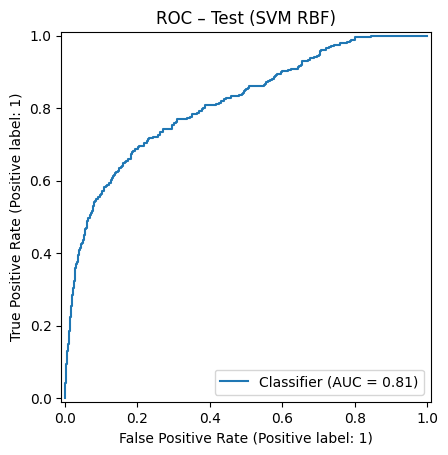

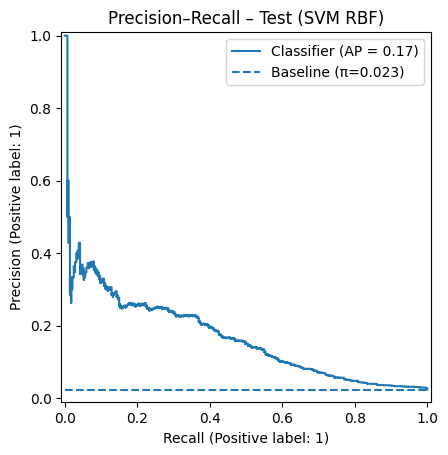


=== Tabla resumen (test) ===


,Escenario,Threshold,ROC-AUC,PR-AUC,Precision(+1),Recall(+1),F1(+1),BalancedAcc,TN,FP,FN,TP
0,Default (signo margen),0 (signo),0.8122,0.1683,0.0327,0.9129,0.0632,0.6337,4252,7743,25,262
1,@τ_F1 (CV en train),0.7939,0.8122,0.1683,0.1462,0.5052,0.2267,0.7173,11148,847,142,145



=== Cross-Validation (train 1999–2014, 5-fold) ===


,métrica,media,std
0,F1,0.1609,0.0020
1,PR-AUC,0.1589,0.0051
2,ROC-AUC,0.6715,0.0077


In [31]:
#  Métricas con UMBRAL
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    RocCurveDisplay, PrecisionRecallDisplay, balanced_accuracy_score
)


y_pred_def = pipe_svm.predict(X_test)
cm_def = confusion_matrix(y_test, y_pred_def)
f1_def = f1_score(y_test, y_pred_def)
balacc_def = balanced_accuracy_score(y_test, y_pred_def)

print("Matriz de confusión (default):\n", cm_def)
print("\nF1(test, default):", round(f1_def, 4), "| BalancedAcc:", round(balacc_def, 4))
print("\nReporte (test, default):\n", classification_report(y_test, y_pred_def, digits=3))

#  Métricas con τ_F1 (opt. en CV-train)
y_pred_tau = (scores_test >= tau_F1).astype(int)
cm_tau = confusion_matrix(y_test, y_pred_tau)
f1_tau = f1_score(y_test, y_pred_tau)
balacc_tau = balanced_accuracy_score(y_test, y_pred_tau)

print("\nMatriz de confusión (test @τ_F1):\n", cm_tau)
print("\nF1(test @τ_F1):", round(f1_tau, 4), "| BalancedAcc:", round(balacc_tau, 4))
print("\nReporte (test @τ_F1):\n", classification_report(y_test, y_pred_tau, digits=3))

#  Gráficas ROC y PR
RocCurveDisplay.from_predictions(y_test, scores_test)
plt.title("ROC – Test (SVM RBF)")
plt.show()

disp = PrecisionRecallDisplay.from_predictions(y_test, scores_test)
plt.title("Precision–Recall – Test (SVM RBF)")
# línea base = prevalencia
plt.hlines(y_test.mean(), 0, 1, linestyles='--', label=f"Baseline (π={y_test.mean():.3f})")
plt.legend()
plt.show()

#  Tabla resumen de métricas (default vs @τ_F1)
def pr_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    return precision, recall, tn, fp, fn, tp

prec_d, rec_d, tn_d, fp_d, fn_d, tp_d = pr_from_cm(cm_def)
prec_t, rec_t, tn_t, fp_t, fn_t, tp_t = pr_from_cm(cm_tau)

from sklearn.metrics import roc_auc_score, average_precision_score

resumen = pd.DataFrame([
    {
        "Escenario": "Default (signo margen)",
        "Threshold": "0 (signo)",
        "ROC-AUC": roc, "PR-AUC": pr,
        "Precision(+1)": prec_d, "Recall(+1)": rec_d,
        "F1(+1)": f1_def, "BalancedAcc": balacc_def,
        "TN": tn_d, "FP": fp_d, "FN": fn_d, "TP": tp_d
    },
    {
        "Escenario": "@τ_F1 (CV en train)",
        "Threshold": f"{tau_F1:.4f}",
        "ROC-AUC": roc, "PR-AUC": pr,
        "Precision(+1)": prec_t, "Recall(+1)": rec_t,
        "F1(+1)": f1_tau, "BalancedAcc": balacc_tau,
        "TN": tn_t, "FP": fp_t, "FN": fn_t, "TP": tp_t
    }
])

resumen_round = resumen.copy()
for col in ["ROC-AUC","PR-AUC","Precision(+1)","Recall(+1)","F1(+1)","BalancedAcc"]:
    resumen_round[col] = resumen_round[col].astype(float).round(4)

print("\n=== Tabla resumen (test) ===")
display(resumen_round)

#  Cross-validation en TRAIN (F1, PR-AUC, ROC-AUC)
from sklearn.model_selection import cross_validate

scoring = {
    "f1": "f1",
    "pr_auc": "average_precision",
    "roc_auc": "roc_auc"
}

cv_res = cross_validate(
    estimator=pipe_svm, X=X_train, y=y_train,
    scoring=scoring, cv=skf, n_jobs=-1, return_train_score=False
)

cv_summary = pd.DataFrame({
    "métrica": ["F1", "PR-AUC", "ROC-AUC"],
    "media":   [cv_res["test_f1"].mean(), cv_res["test_pr_auc"].mean(), cv_res["test_roc_auc"].mean()],
    "std":     [cv_res["test_f1"].std(),  cv_res["test_pr_auc"].std(),  cv_res["test_roc_auc"].std()]
}).round(4)

print("\n=== Cross-Validation (train 1999–2014, 5-fold) ===")
display(cv_summary)
